In [9]:
%matplotlib inline
import datacube
dc = datacube.Datacube(app='dc-example')
import folium
from IPython.display import display
import geopandas
from shapely.geometry import mapping
from shapely.geometry import MultiPolygon
import rasterio
import shapely.geometry
import shapely.ops
from functools import partial
import pyproj
from datacube.model import CRS

from datacube.storage import masking
import pandas

In [10]:
def datasets_union(dss):
    return shapely.ops.unary_union([shapely.geometry.Polygon(ds.extent.to_crs(CRS('EPSG:4326')).points) for ds in dss])

In [ ]:
def plot_folium(shapes):
    style_function = lambda x: {'fillColor': '#000000' if x['type'] == 'Polygon' else '#00ff00'}
    mapa = folium.Map(location=[-30,150], zoom_start=4)
    for shape in shapes:
        poly = folium.features.GeoJson(mapping(shape), style_function=style_function)
        mapa.add_children(poly)
    display(mapa)

In [ ]:
plot_folium([datasets_union(dc.index.datasets.search_eager(product='ls8_ledaps_scene'))])

In [22]:
lordhowe_ledaps = dc.load(product='ls8_ledaps_scene', 
              x=(159.02, 159.13), y=(-31.45, -31.64), 
              time=('2016-3-1', '2016-4-16'),
              #measurements=['sr_band2', 'sr_band3', 'sr_band4'],
              output_crs='EPSG:32657',resolution=(-30,30))

In [23]:
lordhowe_pq = lordhowe_ledaps.cfmask

In [24]:
lordhowe_ledaps_valid = lordhowe_ledaps.where(lordhowe_ledaps != -9999)

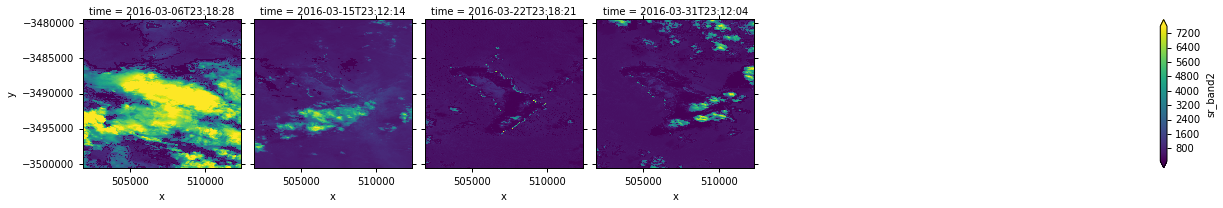

In [25]:
lordhowe_ledaps_valid.sr_band2.plot(col='time', col_wrap=6, robust='True')

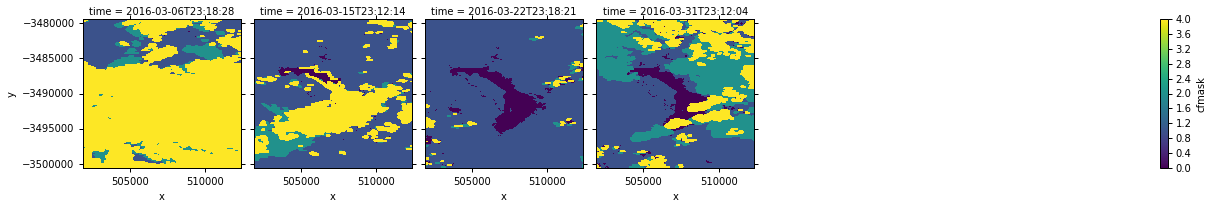

In [26]:
lordhowe_pq.plot(col='time', col_wrap=6, robust='True')

In [27]:
pandas.DataFrame.from_dict(masking.get_flags_def(lordhowe_pq), orient='index')

,values,bits,description
cfmask,"{u'1': u'water', u'0': u'clear', u'3': u'snow'...","[0, 1, 2, 3, 4, 5, 6, 7]",CFmask


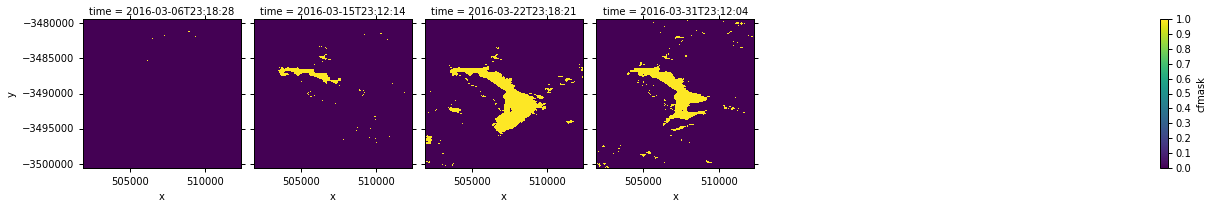

In [28]:
good_data = masking.make_mask(lordhowe_pq, cfmask='clear')
lordhowe_good_data = good_data
lordhowe_good_data.plot(col='time', col_wrap=6)

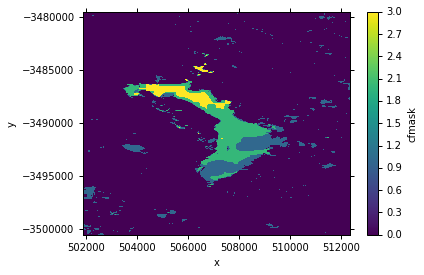

In [29]:
lordhowe_good_data.sum('time').plot()

In [30]:
lordhowe_cloudfree = lordhowe_ledaps_valid.where(lordhowe_good_data)

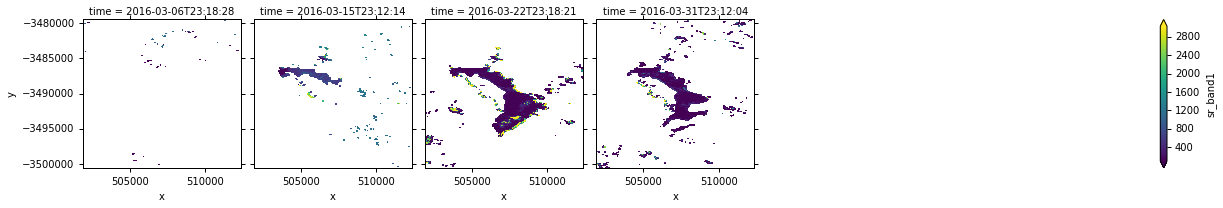

In [31]:
lordhowe_cloudfree.sr_band1.plot(col='time', col_wrap=6, robust='True')

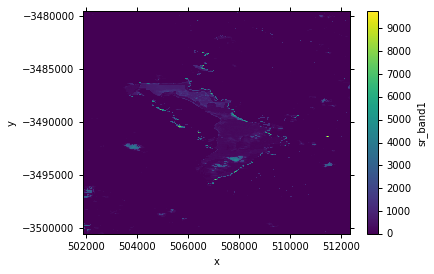

In [32]:
lordhowe_cloudfree.sr_band1.sum(dim='time').plot()

In [16]:
## From http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html
import numpy as np
from skimage import data, img_as_float
from skimage import exposure
from matplotlib import pyplot as plt

In [12]:
def plot_rgb(product, xrange, yrange, trange, red,green,blue,title,index):
    rgb = dc.load(product=product, 
              x=xrange, y=yrange, measurements=[blue, green, red],output_crs='EPSG:32657',resolution=(-30,30))#, 
    rgb_valid = rgb.where(rgb != rgb.variables[blue].attrs['nodata'])
    
    r = np.array(rgb.data_vars[red][index])
    g = np.array(rgb.data_vars[green][index])
    b = np.array(rgb.data_vars[blue][index])
    
    p2, p98 = np.percentile(r, (2, 98))
    r_rescale = exposure.rescale_intensity(r, in_range=(p2, p98))
    p2, p98 = np.percentile(g, (2, 98))
    g_rescale = exposure.rescale_intensity(g, in_range=(p2, p98))
    p2, p98 = np.percentile(b, (2, 98))
    b_rescale = exposure.rescale_intensity(b, in_range=(p2, p98))

    rgb_stack = np.dstack((r_rescale,g_rescale,b_rescale))
    img = img_as_float(rgb_stack)
    return(img)


(1.0, 1.5259021896696422e-05)


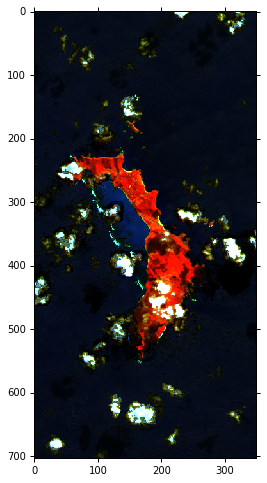

In [35]:
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(plot_rgb('ls8_ledaps_scene', (159.02, 159.13), (-31.45, -31.64), ('2016-3-1', '2016-4-16'),\
         'sr_band5', 'sr_band4', 'sr_band1','Lord Howe LEDAPS',2))

In [42]:
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib
matplotlib.use("Agg")
import numpy as np

In [37]:
manimation.writers.avail

{u'ffmpeg': matplotlib.animation.FFMpegWriter,
 u'ffmpeg_file': matplotlib.animation.FFMpegFileWriter,
 u'imagemagick': matplotlib.animation.ImageMagickWriter,
 u'imagemagick_file': matplotlib.animation.ImageMagickFileWriter}

In [38]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

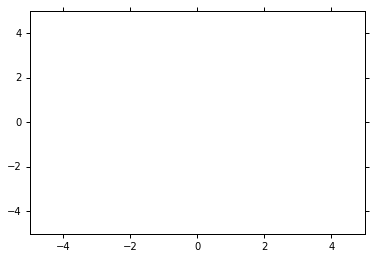

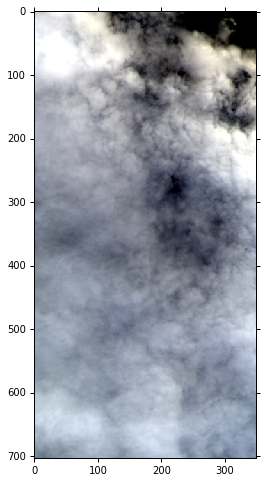

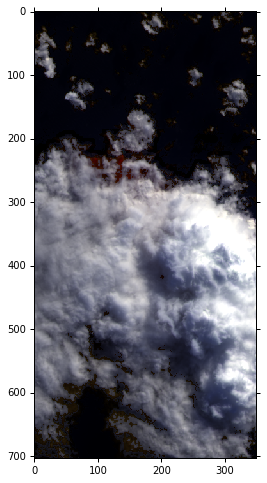

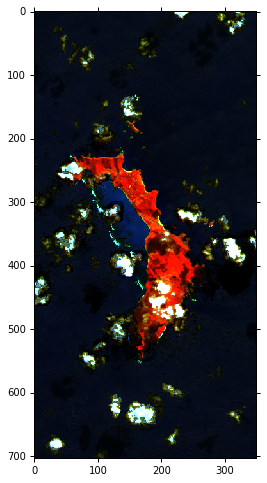

In [41]:


fig = plt.figure()
l, = plt.plot([], [], 'k-o')

plt.xlim(-5, 5)
plt.ylim(-5, 5)

x0, y0 = 0, 0

with writer.saving(fig, "writer_test.mp4", 100):
    for i in range(3):
        #x0 += 0.1 * np.random.randn()
        #y0 += 0.1 * np.random.randn()
        #l.set_data(x0, y0)
        
        plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
        plt.imshow(plot_rgb('ls8_ledaps_scene', (159.02, 159.13), (-31.45, -31.64), ('2016-3-1', '2016-4-16'),\
         'sr_band5', 'sr_band4', 'sr_band1','Lord Howe LEDAPS',i))
        writer.grab_frame()

[MoviePy] >>>> Building video myHolidays_edited.webm
[MoviePy] Writing video myHolidays_edited.webm


 75%|███████▌  | 3/4 [00:00<00:00, 11.15it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: myHolidays_edited.webm 



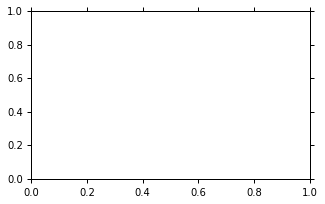

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import *
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
duration = 2
fig_mpl, ax = plt.subplots(1,figsize=(5,3), facecolor='white')

images_list = [plot_rgb('ls8_ledaps_scene', (159.02, 159.13), (-31.45, -31.64), ('2016-3-1', '2016-4-16'),\
         'sr_band5', 'sr_band4', 'sr_band1','Lord Howe LEDAPS',1),plot_rgb('ls8_ledaps_scene', (159.02, 159.13), (-31.45, -31.64), ('2016-3-1', '2016-4-16'),\
         'sr_band5', 'sr_band4', 'sr_band1','Lord Howe LEDAPS',2),plot_rgb('ls8_ledaps_scene', (159.02, 159.13), (-31.45, -31.64), ('2016-3-1', '2016-4-16'),\
         'sr_band5', 'sr_band4', 'sr_band1','Lord Howe LEDAPS',3)]

clip = ImageSequenceClip(images_list, fps=1)
clip.write_videofile("myHolidays_edited.webm")